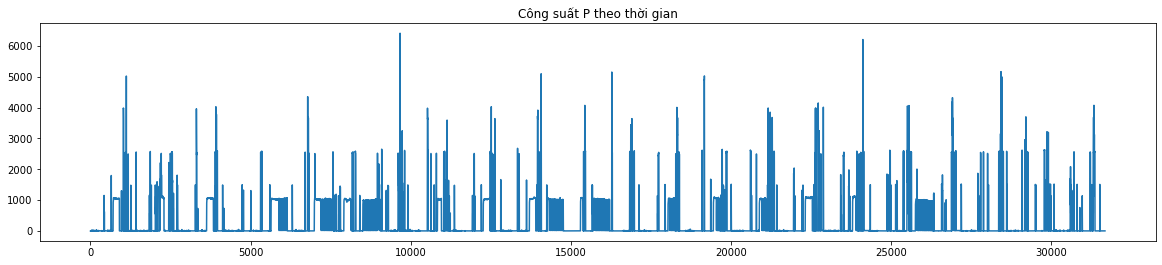

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20, 4)

# ----------READ DATA-------------
# Power dataframe
p_df = pd.read_csv('./data/W.csv',
                   names=['time', 'light', 'socket', 'heater', 'aircond1', 'aircond2', 'aircond3', 'indcooker'],
                   header=0)
# Voltage dataframe
u_df = pd.read_csv('./data/V.csv',
                   names=['time', 'u'],
                   header=0)
# Current dataframe
i_df = pd.read_csv('./data/A.csv',
                   names=['time', 'light', 'socket', 'heater', 'aircond1', 'aircond2', 'aircond3', 'indcooker'],
                   header=0)
# Power factor dataframe
pf_df = pd.read_csv('./data/cosphi.csv',
                    names=['time', 'light', 'socket', 'heater', 'aircond1', 'aircond2', 'aircond3', 'indcooker'],
                    header=0)

# Reactive power dataframe
q_df = pd.DataFrame()
q_df['time'] = p_df['time']
column_names = ['light', 'socket', 'heater', 'aircond1', 'aircond2', 'aircond3', 'indcooker']

# Calculate reactive power using P and cosphi
for col_name in column_names:
    q_df[col_name] = np.tan(np.arccos(pf_df[col_name])) * p_df[col_name]

select_device = ['heater', 'indcooker', 'aircond2']

p_sum = p_df[select_device].sum(axis=1).to_numpy()
q_sum = q_df[select_device].sum(axis=1).to_numpy()
u_sum = u_df['u'].to_numpy()  # không cần tính tổng U, nhưng cứ đặt là u_sum cho đồng nhất
i_sum = i_df[select_device].sum(axis=1).to_numpy() * 100  # Nhân với 100 để I không quá nhỏ

plt.title("Công suất P theo thời gian")
plt.plot(p_sum)
plt.show()

# Prepare data

In [71]:
data = []
label = []
for t in range(0, len(p_sum)):
    data.append([u_sum[t], i_sum[t], p_sum[t], q_sum[t]])
    percent = []
    for j, device_name in enumerate(select_device):
        if p_sum[t] == 0:
            percent.append(0)
        else:
            percent.append(p_df[device_name].iloc[t] / p_sum[t])
    label.append(percent)
        
print("num data point =", len(data))


X = np.array(data)
y = np.array(label)
print(f'{X.shape=}')
print(f'{y.shape=}')
print(f'{X[0:10]=}')
print(f'{y[0:10]=}')

num data point = 31680
X.shape=(31680, 4)
y.shape=(31680, 3)
X[0:10]=array([[231.        ,  25.        ,   1.        ,  49.989999  ],
       [230.        ,  25.        ,   3.5       ,  58.22823866],
       [230.        ,  25.        ,   6.        ,  59.69924623],
       [230.        ,  25.        ,   3.5       ,  58.22823866],
       [230.        ,  25.        ,   1.        ,  49.989999  ],
       [230.        ,  25.        ,   1.        ,  49.989999  ],
       [230.        ,  25.        ,   1.        ,  49.989999  ],
       [230.        ,  25.        ,   4.        ,  57.00268522],
       [230.        ,  25.        ,   5.        ,  58.61064419],
       [230.        ,  25.        ,   2.        ,  57.10784642]])
y[0:10]=array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])


# Implement Multilayer Perceptron 

In [72]:
import numpy as np
from math import exp
from scipy.special import xlogy
from scipy.special import expit as logistic_sigmoid


def sigmoid(x):
    return logistic_sigmoid(x)


def sigmoid_deriv(x):
    sm = sigmoid(x)
    return sm * (1 - sm)


def relu(x):
    return np.maximum(0, x)


def relu_deriv(x):
    ret = np.copy(x)
    ret[ret > 0] = 1
    ret[ret <= 0] = 0
    return ret


def tanh(x):
    return np.tanh(x)


def tanh_deriv(x):
    return 1 - np.exp2(tanh(x))


def identity(x):
    return x


def identity_deriv(x):
    return np.ones(x.shape)


def binary_log_loss(y_true, y_prob):
    eps = np.finfo(y_prob.dtype).eps
    y_prob = np.clip(y_prob, eps, 1 - eps)
    return -(xlogy(y_true, y_prob).sum() +
             xlogy(1 - y_true, 1 - y_prob).sum()) / y_prob.shape[0]


def mse_loss(y_true, y_prob):
    return ((y_true - y_prob) ** 2).sum() / y_prob.shape[0] / 2


ACTIVATIONS = {
    'relu': relu,
    'tanh': tanh,
    'identity': identity,
    'sigmoid': sigmoid
}

DERIVATIVES = {
    'relu': relu_deriv,
    'tanh': tanh_deriv,
    'identity': identity_deriv,
    'sigmoid': sigmoid_deriv
}


def gen_batch(n, batch_size, min_batch_size=0):
    start = 0
    for _ in range(int(n // batch_size)):
        end = start + batch_size
        if end + min_batch_size > n:
            continue
        yield slice(start, end)
        start = end
    if start < n:
        yield slice(start, n)


class MyMLPRegressor():
    def __init__(self,
                 hidden_layer_sizes=(30,),
                 learning_rate=0.001,
                 max_iter=100,
                 random_state=0,
                 tol=0.001,
                 n_iter_no_change=100,
                 beta_1=0.9,
                 beta_2=0.999,
                 epsilon=1e-8,
                 hidden_activation='relu',
                 output_activation='identity',
                 solver='adam',
                 loss_func='mse',
                 batch_size='default'):
        if hidden_activation not in ACTIVATIONS.keys():
            raise AttributeError("Hidden activation function must be in ['relu', 'sigmoid', 'tanh', 'identity']")
        self.hidden_activation_func = ACTIVATIONS[hidden_activation]
        self.hidden_activation_deriv = DERIVATIVES[hidden_activation]

        if output_activation not in ACTIVATIONS.keys():
            raise AttributeError("Output activation function must be in ['sigmoid', 'identity']")
        self.output_activation_func = ACTIVATIONS[output_activation]
        self.output_activation_deriv = DERIVATIVES[output_activation]

        self.solver = solver
        if solver not in ['adam', 'sgd']:
            raise AttributeError("Solver must be 'adam' or 'sgd'")

        self.loss_func = loss_func
        if loss_func not in ['log', 'mse']:
            raise AttributeError("Loss function must be 'log' or 'mse'")

        self.hidden_layer_sizes = hidden_layer_sizes
        self.learning_rate = learning_rate
        self.learning_rate_init = learning_rate
        self.max_iter = max_iter
        self.tol = tol
        self.n_iter_no_change = n_iter_no_change
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon
        self.batch_size = batch_size
        np.random.seed(random_state)

    def fit(self, X, y):
        n_sample, n_feature = X.shape
        hidden_layer_sizes = list(self.hidden_layer_sizes)

        n_input_unit = n_feature
        n_output_unit = y.shape[1]
        layer_units = [n_input_unit] + hidden_layer_sizes + [n_output_unit]
        self.n_layers_ = len(layer_units)

        if self.batch_size == 'default':
            self.batch_size = min(200, n_sample)

        # Weight and bias initialization
        W = [None] * self.n_layers_
        b = [None] * self.n_layers_
        for i in range(1, self.n_layers_):
            factor = 6
            init_bound = np.sqrt(factor / (layer_units[i - 1] + layer_units[i]))
            W[i] = np.random.uniform(-init_bound, init_bound,
                                     (layer_units[i], layer_units[i - 1]))
            b[i] = np.random.uniform(-init_bound, init_bound,
                                     (layer_units[i], 1))

        # Adam algorithm variables
        if self.solver == 'adam':
            VdW = [None] * self.n_layers_
            SdW = [None] * self.n_layers_
            Vdb = [None] * self.n_layers_
            Sdb = [None] * self.n_layers_
            for i in range(1, self.n_layers_):
                VdW[i] = np.zeros((layer_units[i], layer_units[i - 1]))
                SdW[i] = np.zeros((layer_units[i], layer_units[i - 1]))
                Vdb[i] = np.zeros((layer_units[i], 1))
                Sdb[i] = np.zeros((layer_units[i], 1))

        # Main loop
        it = 0
        self.loss_ = []
        while True:
            it += 1
            if it > self.max_iter:
                print(f"Reach {self.max_iter} epochs. Stopping.")

            accumulated_loss = 0

            for batch_slice in gen_batch(n_sample, self.batch_size):
                X_batch = X[batch_slice]
                y_batch = y[batch_slice]

                # Initialize A and Z
                A = [X_batch.T] + [None] * (self.n_layers_ - 1)
                Z = [None] * (self.n_layers_)

                # Forward pass
                for i in range(1, self.n_layers_):
                    Z[i] = np.dot(W[i], A[i - 1]) + b[i]
                    if i != self.n_layers_ - 1:
                        A[i] = self.hidden_activation_func(Z[i])
                    else:
                        A[i] = self.output_activation_func(Z[i])

                # Compute MSE loss for current batch
                if self.loss_func == 'log':
                    batch_loss = binary_log_loss(y_batch, A[-1].T)
                else:
                    batch_loss = mse_loss(y_batch, A[-1].T)
                accumulated_loss += batch_loss * (batch_slice.stop - batch_slice.start)

                # Backpropagation
                dA = [None] * self.n_layers_
                dZ = [None] * self.n_layers_
                dW = [None] * self.n_layers_
                db = [None] * self.n_layers_
                for i in range(self.n_layers_ - 1, 0, -1):
                    if i == self.n_layers_ - 1:
                        if self.loss_func == 'log':
                            dZ[i] = A[-1] - y_batch.T
                        else:
                            dA[i] = A[-1] - y_batch.T
                            dA[i] = - y_batch.T / A[-1] + (1 - y_batch.T) / (1 - A[-1])
                            dZ[i] = dA[i] * self.output_activation_deriv(Z[i])
                    else:
                        dA[i] = np.dot(W[i + 1].T, dZ[i + 1])
                        dZ[i] = dA[i] * self.hidden_activation_deriv(Z[i])
                    dW[i] = np.dot(dZ[i], A[i - 1].T) / n_sample
                    db[i] = np.sum(dZ[i], axis=1, keepdims=True) / n_sample

                # Update params
                if self.solver == 'adam':
                    # adam optimization algorithm
                    for i in range(1, self.n_layers_):
                        VdW[i] = self.beta_1 * VdW[i] + (1 - self.beta_1) * dW[i]
                        Vdb[i] = self.beta_1 * Vdb[i] + (1 - self.beta_1) * db[i]
                        SdW[i] = self.beta_2 * SdW[i] + (1 - self.beta_2) * (dW[i] ** 2)
                        Sdb[i] = self.beta_2 * Sdb[i] + (1 - self.beta_2) * (db[i] ** 2)

                    # correct the first loops
                    # if it < 20:
                    #     for i in range(1, self.n_layers_):
                    #         VdW[i] = VdW[i] / (1 - self.beta_1 ** it)
                    #         Vdb[i] = Vdb[i] / (1 - self.beta_1 ** it)
                    #         SdW[i] = SdW[i] / (1 - self.beta_2 ** it)
                    #         Sdb[i] = Sdb[i] / (1 - self.beta_2 ** it)

                    # update params
                    for i in range(1, self.n_layers_):
                        W[i] = W[i] - self.learning_rate * VdW[i] / (np.sqrt(SdW[i]) + self.epsilon)
                        b[i] = b[i] - self.learning_rate * Vdb[i] / (np.sqrt(Sdb[i]) + self.epsilon)

                    self.learning_rate = (self.learning_rate_init *
                                          np.sqrt(1 - self.beta_2 ** it) /
                                          (1 - self.beta_1 ** it))
                else:
                    W[i] = W[i] - self.learning_rate * dW[i]
                    b[i] = b[i] - self.learning_rate * db[i]

            # All batches done
            # Compute loss
            loss = accumulated_loss / n_sample
            print(f'Iteration={it} {loss=}')
            self.loss_.append(loss)

            # Check convergence
            if it > self.n_iter_no_change:
                if self.loss_[-self.n_iter_no_change] - self.loss_[-1] < self.tol:
                    print(
                        f'Training loss did not improve more than {self.tol=} for {self.n_iter_no_change} consecutive epochs. Stopping.')
                    break

        self.W_ = W
        self.b_ = b

    def predict(self, X):
        W = self.W_
        b = self.b_

        Z = [None] * self.n_layers_
        A = [X.T] + [None] * (self.n_layers_ - 1)
        for i in range(1, self.n_layers_):
            Z[i] = np.dot(W[i], A[i - 1]) + b[i]
            if i != self.n_layers_ - 1:
                A[i] = self.hidden_activation_func(Z[i])
            else:
                A[i] = self.output_activation_func(Z[i])

        return A[-1].T

    def score(self, X_test, y_test):
        y_pred = self.predict(X_test)
        u = ((y_test - y_pred) ** 2).sum()
        v = ((y_test - y_test.mean()) ** 2).sum()
        return 1 - u / v

# Train and test

In [75]:
model = MyMLPRegressor(
                    hidden_layer_sizes=(40,),
                    learning_rate=0.001,
                    random_state=0,
                    max_iter=100000,
                    n_iter_no_change=20,
                    tol=0.001,
                    hidden_activation='tanh',
                    output_activation='sigmoid',
                    solver='adam',
                    loss_func='mse',
                    batch_size=200)
model.fit(X, y)
score = model.score(X, y)
print("Score=", score)

Iteration=1 loss=0.18285974836907554
Iteration=2 loss=0.16317496878937351
Iteration=3 loss=0.15228876457881002
Iteration=4 loss=0.14530859398346274
Iteration=5 loss=0.14442336192121175
Iteration=6 loss=0.1430187921854748
Iteration=7 loss=0.1440640525288544
Iteration=8 loss=0.14569678745445236
Iteration=9 loss=0.14554571494566118
Iteration=10 loss=0.14489660037836188
Iteration=11 loss=0.14188329977520062
Iteration=12 loss=0.1399500490117848
Iteration=13 loss=0.1420106020686144
Iteration=14 loss=0.14263608256154411
Iteration=15 loss=0.14268872168489802
Iteration=16 loss=0.14179915352093994
Iteration=17 loss=0.14074900032887522
Iteration=18 loss=0.13974429251830478
Iteration=19 loss=0.13984851093932965
Iteration=20 loss=0.13973598456599043
Iteration=21 loss=0.13949777039411945
Iteration=22 loss=0.13893649471972544
Iteration=23 loss=0.13832118211398745
Iteration=24 loss=0.13778552543987171
Iteration=25 loss=0.13789674870654087
Iteration=26 loss=0.13753561443294518
Iteration=27 loss=0.13757

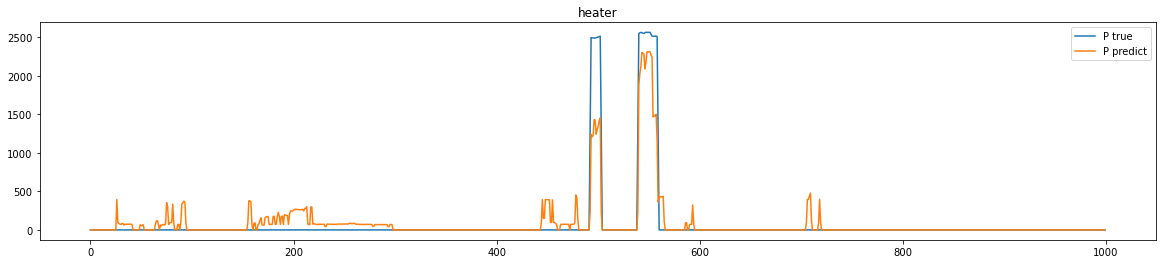

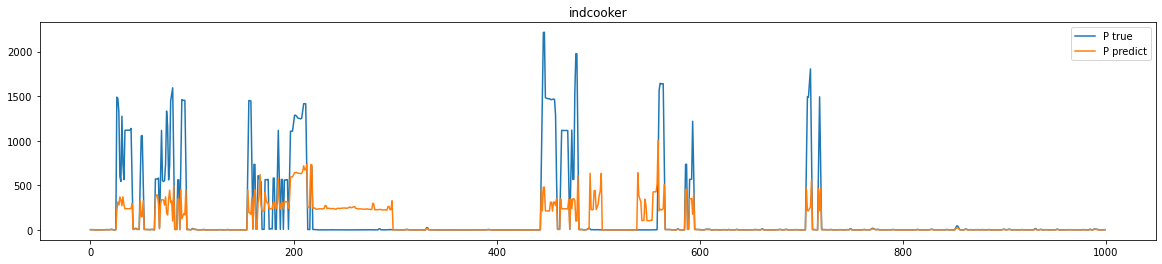

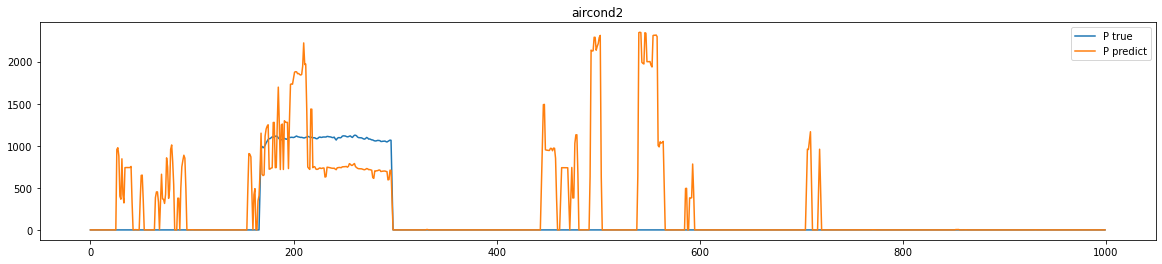

In [76]:
yhat = model.predict(X)
a = 2000
b = 3000
for i in range(y.shape[1]):
    plt.plot(y[a:b, i] * p_sum[a:b])
    plt.plot(yhat[a:b, i] * p_sum[a:b])
    plt.title(select_device[i])
    plt.legend(['P true', 'P predict'])
    plt.show()